In [1]:
import brian2 as b2
from brian2 import NeuronGroup, Synapses, PoissonInput, PoissonGroup, network_operation
from brian2.monitors import StateMonitor, SpikeMonitor, PopulationRateMonitor
from random import sample
import numpy.random as rnd
from neurodynex3.tools import plot_tools
import numpy
import matplotlib.pyplot as plt
from math import floor
import time
import pickle

b2.defaultclock.dt = 0.10 * b2.ms

from brian2 import *




In [2]:
def nmda_by_x(x_rate, w_pos):
    
    start_scope()
    #w_pos = 1.9
    N_Excit=384
    N_Inhib=96
    weight_scaling_factor=5.33
    t_stimulus_start=100 * b2.ms
    t_stimulus_duration=9999 * b2.ms
    coherence_level=0.
    stimulus_update_interval=30 * b2.ms
    mu0_mean_stimulus_Hz=250.
    stimulus_std_Hz=20.
    N_extern=1000
    firing_rate_extern=9.8 * b2.Hz
    f_Subpop_size=0.25  # .15 in publication [1]                     
    max_sim_time=1000. * b2.ms 
    stop_condition_rate=None

    monitored_subset_size=512, 
    E_leak_excit = -70.0 * b2.mV

    print("simulating {} neurons. Start: {}".format(N_Excit + N_Inhib, time.ctime()))
    t_stimulus_end = t_stimulus_start + t_stimulus_duration

    N_Group_A = int(N_Excit * f_Subpop_size)  # size of the excitatory subpopulation sensitive to stimulus A
    N_Group_B = N_Group_A  # size of the excitatory subpopulation sensitive to stimulus B
    N_Group_Z = N_Excit - N_Group_A - N_Group_B  # (1-2f)Ne excitatory neurons do not respond to either stimulus.

    Cm_excit = 0.5 * b2.nF  # membrane capacitance of excitatory neurons
    G_leak_excit = 25.0 * b2.nS  # leak conductance
    E_leak_excit = -70.0 * b2.mV  # reversal potential   #######################################################
    v_spike_thr_excit = -50.0 * b2.mV  # spike condition
    v_reset_excit = -60.0 * b2.mV  # reset voltage after spike
    t_abs_refract_excit = 2. * b2.ms  # absolute refractory period

    # specify the inhibitory interneurons:
    # N_Inhib = 200
    Cm_inhib = 0.2 * b2.nF
    G_leak_inhib = 20.0 * b2.nS
    E_leak_inhib = -90.0 * b2.mV
    v_spike_thr_inhib = -50.0 * b2.mV
    v_reset_inhib = -60.0 * b2.mV
    t_abs_refract_inhib = 1.0 * b2.ms

    # specify the AMPA synapses
    E_AMPA = 0.0 * b2.mV
    tau_AMPA = 2.5 * b2.ms

    # specify the GABA synapses
    E_GABA = -70.0 * b2.mV
    tau_GABA = 5.0 * b2.ms

    # specify the NMDA synapses
    E_NMDA = 0.0 * b2.mV
    tau_NMDA_s = 100.0 * b2.ms
    tau_NMDA_x = 2. * b2.ms
    alpha_NMDA = 0.5 * b2.kHz

    # projections from the external population
    g_AMPA_extern2inhib = 1.62 * b2.nS
    g_AMPA_extern2excit = 2.1 * b2.nS

    # projectsions from the inhibitory populations
    g_GABA_inhib2inhib = weight_scaling_factor * 1.25 * b2.nS
    g_GABA_inhib2excit = weight_scaling_factor * 1.60 * b2.nS

    # projections from the excitatory population
    g_AMPA_excit2excit = weight_scaling_factor * 0.012 * b2.nS
    g_AMPA_excit2inhib = weight_scaling_factor * 0.015 * b2.nS
    g_NMDA_excit2excit = weight_scaling_factor * 0.040 * b2.nS
    g_NMDA_excit2inhib = weight_scaling_factor * 0.045 * b2.nS  # stronger projection to inhib.

    # weights and "adjusted" weights.
    w_neg = 1. - f_Subpop_size * (w_pos - 1.) / (1. - f_Subpop_size)
    # We use the same postsyn AMPA and NMDA conductances. Adjust the weights coming from different sources:
    w_ext2inhib = g_AMPA_extern2inhib / g_AMPA_excit2inhib
    w_ext2excit = g_AMPA_extern2excit / g_AMPA_excit2excit
    # other weights are 1
    # print("w_neg={}, w_ext2inhib={}, w_ext2excit={}".format(w_neg, w_ext2inhib, w_ext2excit))A
    # Define the inhibitory population



    excit_lif_dynamics = """
            s_NMDA_total : 1  # the post synaptic sum of s. compare with s_NMDA_presyn
            dv/dt = (
            - G_leak_excit * (v-E_leak_excit)
            - g_AMPA_excit2excit * s_AMPA * (v-E_AMPA)
            - g_GABA_inhib2excit * s_GABA * (v-E_GABA)
            - g_NMDA_excit2excit * s_NMDA_total * (v-E_NMDA)/(1.0+1.0*exp(-0.062*v/volt)/3.57)
            )/Cm_excit : volt (unless refractory)
            ds_AMPA/dt = -s_AMPA/tau_AMPA : 1
            ds_GABA/dt = -s_GABA/tau_GABA : 1
            ds_NMDA/dt = -s_NMDA/tau_NMDA_s + alpha_NMDA * x * (1-s_NMDA) : 1
            dx/dt = -x/tau_NMDA_x : 1
        """
    
    excit_lif_dynamics_nmda = """
            s_NMDA_total : 1  # the post synaptic sum of s. compare with s_NMDA_presyn
            dv/dt = (
            - G_leak_excit * (v-E_leak_excit)
            - g_AMPA_excit2excit * s_AMPA * (v-E_AMPA)
            - g_GABA_inhib2excit * s_GABA * (v-E_GABA)
            - g_NMDA_excit2excit * s_NMDA_total * (v-E_NMDA)/(1.0+1.0*exp(-0.062*v/volt)/3.57)
            )/Cm_excit : volt (unless refractory)
            ds_AMPA/dt = -s_AMPA/tau_AMPA : 1
            ds_GABA/dt = -s_GABA/tau_GABA : 1
            ds_NMDA/dt = -s_NMDA/tau_NMDA_s + alpha_NMDA * x * (1-s_NMDA) : 1
            dx/dt = -x/tau_NMDA_x : 1
        """


    one_neuron = NeuronGroup(1, model=excit_lif_dynamics_nmda,
                            threshold="v>v_spike_thr_excit", reset="v=v_reset_excit",
                            refractory=t_abs_refract_excit, method="rk2")

    one_neuron.v = rnd.uniform(E_leak_excit / b2.mV, high=E_leak_excit / b2.mV + 5., size=one_neuron.N) * b2.mV




    # network parameters
    N_E = 1000
    gamma = 0.25
    N_I = round(gamma * N_E)
    N = N_E + N_I
    epsilon = 0.1
    C_E = epsilon * N_E
    C_ext = C_E

    # neuron parameters
    tau = 10 * ms
    theta = 1 * mV
    V_r = 0 * mV
    tau_rp = 2 * ms

    # synapse parameters
    J = 0.1 * mV
    D = 1.5 * ms
    nu_ext = 10 *Hz
    # external stimulus
    nu_thr = theta / (J * C_E * tau)

    defaultclock.dt = 0.1 * ms

    Poisson_NE = 1000
    g = 1

    #w_pos= 1.9



    # with and without NMDA 와 비교하기 
    exc_poisson_input = PoissonInput(
            target=one_neuron, target_var="s_AMPA", N=N_E, rate=1*nu_ext, weight= w_ext2excit)       

    inh_poisson_input = PoissonInput(
            target=one_neuron, target_var="s_GABA", N=N_I, rate=1*nu_ext, weight= w_ext2inhib)

    nmda_poisson_input = PoissonInput(
            target=one_neuron, target_var="x", N=1, rate= x_rate*Hz, weight= 1 )

    #NDMA input 
    sNMDA_A_total = []

    @network_operation()
    def update_nmda_sum():
            sum_sNMDA_A = 300*sum(one_neuron.s_NMDA)

            #sum_sNMDA_A = 100

            # note the _ at the end of s_NMDA_total_ disables unit checking
            one_neuron.s_NMDA_total_ = (w_pos * sum_sNMDA_A)  ## 자기 자신의 nmda input 만을 받는다. 
            sNMDA_A_total.append(sum_sNMDA_A)


    # set a self-recurrent synapse to introduce a delay when updating the intermediate
    # gating variable x

    syn_x_A2A = Synapses(one_neuron, one_neuron, on_pre="x += 1.", delay=0.5 * b2.ms)
    syn_x_A2A.connect(j="i")

    rmp_monitor = StateMonitor(one_neuron, 'v', record = 0)

    x_monitor = StateMonitor(one_neuron, 'x', record = 0)
    s_monitor = StateMonitor(one_neuron, 's_NMDA', record = 0)


    rmp_in_mV = 1000*(rmp_monitor.v[0])

    rmp_in_mV = 1000*(rmp_monitor.v[0])




    run(1200*ms, report='text')

    time_in_ms = (rmp_monitor.t/ms)/1000
    rmp_in_mV = (rmp_monitor.v[0])/b2.mV
    
    
    return time_in_ms, rmp_in_mV   # the unit is ms and mV 

  
    

In [3]:
a = nmda_by_x(100, 2.2)

simulating 480 neurons. Start: Thu Dec  8 15:23:40 2022


clang-13: error: the clang compiler does not support '-march=native'
WARNING    Cannot use Cython, a test compilation failed: command '/Users/minsu/miniforge3/envs/bmnn2/bin/arm64-apple-darwin20.0.0-clang' failed with exit code 1 (CompileError) [brian2.codegen.runtime.cython_rt.cython_rt.failed_compile_test]
INFO       Cannot use compiled code, falling back to the numpy code generation target. Note that this will likely be slower than using compiled code. Set the code generation to numpy manually to avoid this message:
prefs.codegen.target = "numpy" [brian2.devices.device.codegen_fallback]


Starting simulation at t=0. s for a duration of 1.2 s
1.2 s (100%) simulated in 1s


In [4]:
a[0]

array([0.0000e+00, 1.0000e-04, 2.0000e-04, ..., 1.1997e+00, 1.1998e+00,
       1.1999e+00])

In [5]:
num_time = len(a[0])

In [6]:
num_trial = 100

In [7]:
rmp_mat = numpy.zeros([num_trial, num_time])



In [8]:
rmp_mat[:10]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [11]:
for trial_idx in range((100)):
    result = nmda_by_x(100, 1.5)
    rmp = result[1]
    rmp_mat[trial_idx,:] = rmp
    
    

simulating 480 neurons. Start: Thu Dec  8 15:24:03 2022
Starting simulation at t=0. s for a duration of 1.2 s
1.2 s (100%) simulated in 1s
simulating 480 neurons. Start: Thu Dec  8 15:24:05 2022
Starting simulation at t=0. s for a duration of 1.2 s
1.2 s (100%) simulated in 1s
simulating 480 neurons. Start: Thu Dec  8 15:24:07 2022
Starting simulation at t=0. s for a duration of 1.2 s
1.2 s (100%) simulated in 1s
simulating 480 neurons. Start: Thu Dec  8 15:24:09 2022
Starting simulation at t=0. s for a duration of 1.2 s
1.2 s (100%) simulated in 1s
simulating 480 neurons. Start: Thu Dec  8 15:24:11 2022
Starting simulation at t=0. s for a duration of 1.2 s
1.2 s (100%) simulated in 1s
simulating 480 neurons. Start: Thu Dec  8 15:24:13 2022
Starting simulation at t=0. s for a duration of 1.2 s
1.2 s (100%) simulated in 1s
simulating 480 neurons. Start: Thu Dec  8 15:24:15 2022
Starting simulation at t=0. s for a duration of 1.2 s
1.2 s (100%) simulated in 1s
simulating 480 neurons. Sta

In [12]:
rmp_mean_1p5 = numpy.mean(rmp_mat, axis=0)
rmp_sem_1p5 = numpy.std(rmp_mat, axis=0)/numpy.sqrt(num_trial)

In [13]:
rmp_mat = numpy.zeros([num_trial, num_time])


In [14]:
for trial_idx in range((100)):
    result = nmda_by_x(100, 2.2)
    rmp = result[1]
    rmp_mat[trial_idx,:] = rmp
    
    

simulating 480 neurons. Start: Thu Dec  8 15:36:58 2022
Starting simulation at t=0. s for a duration of 1.2 s
1.2 s (100%) simulated in 1s
simulating 480 neurons. Start: Thu Dec  8 15:37:00 2022
Starting simulation at t=0. s for a duration of 1.2 s
1.2 s (100%) simulated in 1s
simulating 480 neurons. Start: Thu Dec  8 15:37:02 2022
Starting simulation at t=0. s for a duration of 1.2 s
1.2 s (100%) simulated in 1s
simulating 480 neurons. Start: Thu Dec  8 15:37:04 2022
Starting simulation at t=0. s for a duration of 1.2 s
1.2 s (100%) simulated in 1s
simulating 480 neurons. Start: Thu Dec  8 15:37:06 2022
Starting simulation at t=0. s for a duration of 1.2 s
1.2 s (100%) simulated in 1s
simulating 480 neurons. Start: Thu Dec  8 15:37:08 2022
Starting simulation at t=0. s for a duration of 1.2 s
1.2 s (100%) simulated in 1s
simulating 480 neurons. Start: Thu Dec  8 15:37:10 2022
Starting simulation at t=0. s for a duration of 1.2 s
1.2 s (100%) simulated in 1s
simulating 480 neurons. Sta

In [15]:
time = result[0]

In [16]:
rmp_mean = numpy.mean(rmp_mat, axis=0)
rmp_sem = numpy.std(rmp_mat, axis=0)/numpy.sqrt(num_trial)

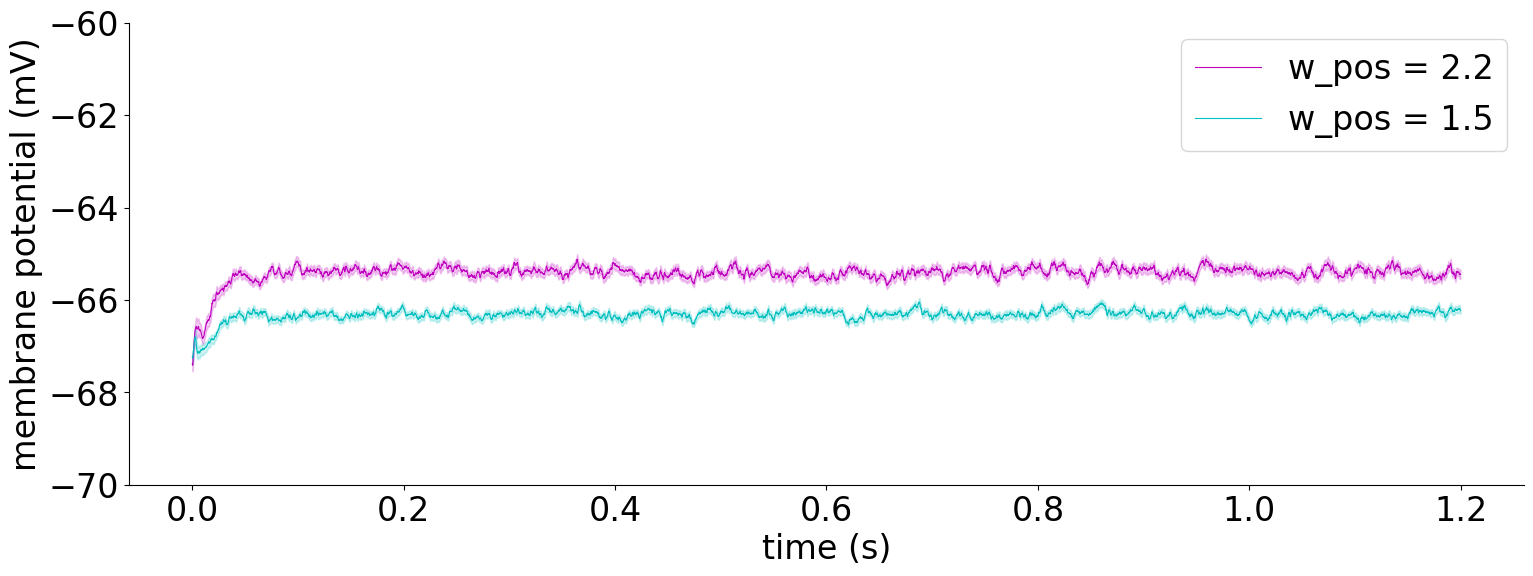

In [18]:


fig, ax = plt.subplots(1,figsize=(18, 6))

ax.plot(result[0], rmp_mean, 'm-', label='w_pos = 2.2', linewidth=0.8) 
ax.fill_between(time, rmp_mean - rmp_sem, rmp_mean + rmp_sem, color='m', alpha=0.2)

ax.plot(result[0], rmp_mean_1p5, 'c-', label='w_pos = 1.5', linewidth=0.8) 
ax.fill_between(time, rmp_mean_1p5 - rmp_sem_1p5, rmp_mean_1p5 + rmp_sem_1p5, color='c', alpha=0.2)



ax.set_ylim([-70, -60])

ax.legend()


ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)



ax.set_xlabel('time (s)')
ax.set_ylabel('membrane potential (mV)')
plt.rcParams.update({'font.size': 24})
plt.savefig("figure6_one_cell_by_w_pos_nmda_input.svg", transparent=True)    



plt.show()

In [ ]:
rmp_100trials_by_nmda_w_pos_1p5

In [27]:
with open('rmp_100trials_by_nmda_w_pos_1p5.pickle', 'rb') as f:
    rmp_mat_1p5 = pickle.load(f)